In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dropout
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad, Adadelta, Adamax, Nadam, Optimizer
import matplotlib.pyplot as plt
from typing import List, Union
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
%matplotlib inline

## Exploring our Data

In [2]:
data_folder = os.path.join(os.getcwd(), '..',  'Data', 'Kaggle MNIST Digits')

So what's in the data folder?

In [3]:
print(os.listdir(data_folder))

['test.csv', 'train.csv']


Next let's load and look at what data is inside `train.csv`:

In [4]:
train_data = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test_data = pd.read_csv(os.path.join(data_folder, 'test.csv'))
print('Shape:',train_data.shape)
train_data.head()

Shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The data consists of a label, i.e. 0-9 and 784 feature columns with values 0-255 for pixel intensity. Because the images are of size 28x28, we end up with 784 feature columns.

Next let's cleanup the data a bit. We do this by removing the label column for training purposes. It would be pretty silly to train a neural network with the answer as part of the input! We will also normalize the data by dividing input values by the max possible value, which in this case is 255. This makes it so all values are treated equally.

In [5]:
Y_train = train_data['label'].values
X_train = train_data.drop(columns=['label']).values / 255.0
X_test = test_data.values / 255.0

## Some Examples of Input Data

It is often very useful to be able to see what the input data is. The above output of pixel values doesn't quite do it for me. Let's instead convert the 784 feature column back into 28x28 images. You can probably already imagine what the data will look like.

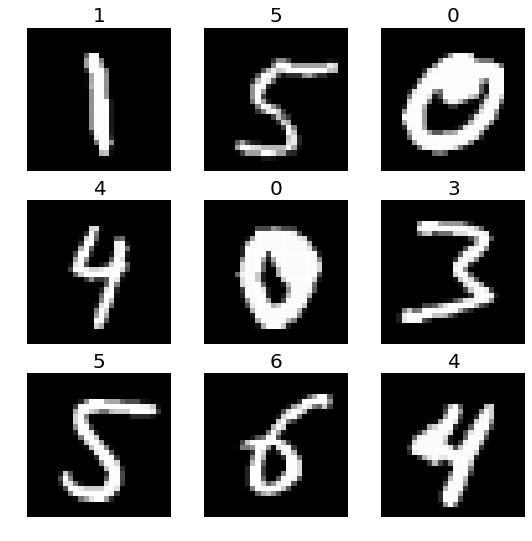

In [6]:
np.random.seed(0xBEEF)  # Reproducibility
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.ravel()
indices = np.random.randint(0, train_data.shape[0], size=9)  # Grab 9 random indices from train data
for i in range(9):
    axes[i].imshow(X_train[indices[i], :].reshape(28, 28), cmap='gray')
    axes[i].axis('off')  # Nobody cares about the axes :(
    label = Y_train[indices[i]]  # The actual label for this data
    axes[i].set_title(label, fontsize=20)
plt.show()

As you can see, the images are numbers. Once again, computers do not see these as a number. Let's look at what the computer sees quickly. I will print out how the computer sees the "1" in the upper left of the images from above:

In [7]:
print('Label:', Y_train[indices[0]])
print('Array:\n',  X_train[indices[0], :].reshape(28, 28))

Label: 1
Array:
 [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  

## Creating the Network

First we need something to be able to model the network. This is pretty easy to do with TensorFlow and Keras. I will start by defining a function to use as a template for creating a layer with some number of hidden units.

In [8]:
def multi_layer_network(num_inputs: int, num_outputs: int, 
                        hidden_layer_sizes: List[int], 
                        activations: List[str],
                        optimizer: Optimizer) -> Sequential:
    """
    Creates a fully connected Neural Network where
        num_inputs: Number of input features exluding the bias
        num_outputs: Number of outputs
        hidden_layer_sizes: A list representing the number of hidden units in each layer
        activations: A list containing which activation to use after each layer
        optimizer: An optimizer to use
    """
    assert len(hidden_layer_sizes) == len(activations), 'activations need to be the same length as hidden_layer_sizes'
    num_layers = len(hidden_layer_sizes) + 1
    model = Sequential(name="{} layer Neural Networ".format(num_layers))
    
    first_layer = True
    
    # Add the hidden layers
    for layer in range(len(hidden_layer_sizes)):
        layer_name = 'Layer' + str(layer)
        # First layer we will define the input_shape
        if first_layer:
            model.add(Dense(hidden_layer_sizes[layer],activation=activations[layer],
                            name='Input', input_shape=(num_inputs,)))
            first_layer = False
        else:
            model.add(Dense(hidden_layer_sizes[layer], activation=activations[layer],
                            name=layer_name))
    
    # Add output
    model.add(Dense(num_outputs, activation='softmax', name='Output'))
    
    # Compile the model
    # categorical_ctrossentropy is used since I'll be using one-hot
    model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

optimizer = Adam()
h_layers = [256]
activations = ['relu']
num_inputs = X_train.shape[1]
num_outputs = len(set(Y_train))

model = multi_layer_network(num_inputs, num_outputs, h_layers, activations, optimizer)
plot_model(model, show_shapes=True, to_file='simple_NN.png')

Instructions for updating:
Colocations handled automatically by placer.


![Simple Neural Network Model](simple_NN.png)

As you can see from the image above, the model is quite simple. It consists of 784 inputs (the pixel values), followed by 256 nodes in the hidden layers, and finally 10 outputs. These outputs are one-hot encoded, meaning all outputs are of the same shape and can only have one value of "1", while the rest of the values are "0". An example would be:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0: \[1, 0, 0, 0, 0, 0, 0, 0, 0, 0\],<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1: \[0, 1, 0, 0, 0, 0, 0, 0, 0, 0\],<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2: \[0, 0, 1, 0, 0, 0, 0, 0, 0, 0\],<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;...<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;9: \[0, 0, 0, 0, 0, 0, 0, 0, 0, 1\],<br>

In [9]:
seed=0
Y_train = to_categorical(Y_train, num_classes=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=.2, random_state=seed)

In [10]:
model.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), verbose=0)

Instructions for updating:
Use tf.cast instead.


Now for a quick evaluation of our model on our validation data:

In [11]:
model.evaluate(X_val, Y_val)

8400/8400 [==============================] - 0s 50us/sample - loss: 0.1682 - acc: 0.9764


[0.1681896529137819, 0.97642857]

97.9% accuracy on the validation data. This isn't bad, but also not great, especially for this specific problem. Now I will save the prediction and submit it to Kaggle to see how it compares to other models.

In [12]:
Y_hat = model.predict(X_test)

In [13]:
Y_hat.shape

(28000, 10)

In [14]:
Y_pred = np.argmax(Y_hat, axis=1)
Y_pred.shape

(28000,)

In [15]:
def save_to_csv(prediction, fname):
    result = pd.Series(prediction, name='Label')
    submission = pd.concat([pd.Series(range(1, prediction.shape[0] + 1), name='ImageId'), result],
                          axis=1)
    submission.to_csv(fname, index=False)
    
save_to_csv(Y_pred, 'prediction_NN.csv')

This gives ~97% accuracy. This only lands me in top 67% of the Kaggle competition (more on this later). One thing we can do is create a deeper Neural Network and see if it can better generalize the problem.

## Deep Neural Network

You have seen how a Neural Network with one hidden layers performs. Now let's see how a Deep Neural Network with 3 hidden layers performs! For this I will use the Adam optimizer with default arguments and hidden layers with 256, 128 and 64 nodes in them.

In [16]:
optimizer = Adam()
h_layers = [256, 128, 64]
activations = ['relu'] * 3
num_inputs = X_train.shape[1]

model = multi_layer_network(num_inputs, num_outputs, h_layers, activations, optimizer)
plot_model(model, to_file='DeepNN.png', show_shapes=True)

![Deep Neural Network](DeepNN.png)

In [17]:
model.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), verbose=0)

Now let's see how the model performs on our validation data!

In [18]:
model.evaluate(X_val, Y_val)

8400/8400 [==============================] - 0s 53us/sample - loss: 0.1721 - acc: 0.9769


[0.17212830743255916, 0.97690475]

In [19]:
Y_hat = model.predict(X_test)
Y_pred = np.argmax(Y_hat, axis=1)
save_to_csv(Y_pred, 'prediction_DNN.csv')

Just this simple change, which is really just a change of hyperparameters, caused me to get 97.7% accuracy and move to top 60% in the competition. Although the model performs slightly worse on validation data, it seems to generalize better.

## Using a Convolutional Neural Network

From the previous steps you can see that a simple Neural Network performs pretty well on this data. Since this data is just a bunch of images, one thing to try is a Convolutional Neural Network (CNN). At a high level a CNN is a Neural Network Architecture that transforms inputs to outputs. Normally, in a fully connected Neural Network, each input is connected to each node in the hidden layer. With a CNN, however, only a small number of inputs are connected to each node in the hidden layer. For a Neural Netowrk you also have individual weights for each input to node in the hidden layer. When using a CNN, the weights and biases are shared for all hidden units within a layer. This means the neurons are detecting the same feature across the image. This makes the Network tolerant to things like rotation and scaling. We can also use pooling within a CNN to reduce the dimensionality, which then reduces the number of parameters that the Network needs to learn. Let's get started!

In [20]:
def build_cnn():
    model = Sequential(name='CNN')
    
    # Conv + Batch norm + Conv + MaxPool + Dropout
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu',
                    input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))  # Downscale
    model.add(Dropout(rate=.25))
    
    # Conv + Batch norm + Conv + MaxPool + Dropout
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))  # Downscale
    model.add(Dropout(rate=.25))
    
    # Flatten + Dense + D ropout + Dense (output)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=.5))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=.2, patience=5, min_lr=1e-5, verbose=1)

In [22]:
cnn_model = build_cnn()
X_train_img = X_train.reshape(-1, 28, 28, 1)
X_val_img = X_val.reshape(-1, 28, 28, 1)
X_test_img = X_test.reshape(-1, 28, 28, 1)
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


![CNN Model](cnn_model.png)

In [23]:
cnn_model.fit(X_train_img, Y_train, epochs=10, validation_data=(X_val_img, Y_val), verbose=0)

Quickly taking a look to see how it performs on the validation data:

In [24]:
cnn_model.evaluate(X_val_img, Y_val)

8400/8400 [==============================] - 1s 86us/sample - loss: 0.0314 - acc: 0.9925


[0.03139312790535942, 0.9925]

In [25]:
Y_hat_img = cnn_model.predict(X_test_img)
Y_pred_img = np.argmax(Y_hat_img, axis=1)
save_to_csv(Y_pred_img, 'simple_CNN.csv')

This has an accuracy of 99.2% and landed me in the top 32%. Ways to improve this are pretty much the same for any supervised learning task: try different Network architectures, tune hyperparameters, train longer, train on more data.

## Augmenting Data

Although there are many things I could do to make the CNN Architecture better, I'm going to keep it the same and just add more data. One thing to note is we could train multiple Networks and have them compete against each other and average their weights. This does take longer but often produces better results. Since I will be augmenting a good amount of data, I'm also going to add a callback to the model that allows it to reduce the learning rate if it has not improved in a while. Let's see how this is done!

In [26]:
epochs = 50
datagen = ImageDataGenerator(
    rotation_range=10,  # Randomly rotate image within range
    zoom_range = 0.1,  # Randomly zoom in/out
    width_shift_range=0.1,  # Shift (fraction of total)
    height_shift_range=0.1,  # Shift (fraction of total)
)
datagen.fit(X_train_img)

In [27]:
cnn_model_datagen = build_cnn()

In [28]:
history = cnn_model_datagen.fit_generator(datagen.flow(X_train_img, Y_train, batch_size=64),
                                         epochs=epochs, steps_per_epoch=X_train_img.shape[0]//64,
                                         validation_data=(X_val_img, Y_val),
                                         callbacks=[reduce_lr],
                                         verbose=0)

8400/8400 [==============================] - 1s 71us/sample - loss: 0.0286 - acc: 0.9933

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
8400/8400 [==============================] - 1s 70us/sample - loss: 0.0175 - acc: 0.9955

Epoch 00036: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
8400/8400 [==============================] - 1s 70us/sample - loss: 0.0169 - acc: 0.9962

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1e-05.
8400/8400 [==============================] - 1s 71us/sample - loss: 0.0167 - acc: 0.9963


Once again taking a look at how it performs on validation data:

In [29]:
cnn_model_datagen.evaluate(X_val_img, Y_val)

8400/8400 [==============================] - 1s 87us/sample - loss: 0.0167 - acc: 0.9963


[0.01668680108270705, 0.9963095]

You can see that although we do better than the previous model, we do get stuck as I reduce the learning rate. I used a watcher for the learning rate to try to improve accuracy. This makes it so if the validation accuracy plateaus for a a number of epochs, it will reduce it by some fraction, in this case .2. This could be modified and re-ran for better results, but for now I will keep it how it is. Adjusting the learning rate in this way is a good example of hyperparameter tuning. Remember, a hyperparameter is a parameter which controls the overall algorithm. Other types of hyperparameters are number of hidden units in a layer, number of hidden layers, etc.

In [30]:
Y_hat_img = cnn_model_datagen.predict(X_test_img)
Y_pred_img = np.argmax(Y_hat_img, axis=1)
save_to_csv(Y_pred_img, 'simple_CNN_datagen.csv')

This gets 99.6% accuracy and moved me to top 13%.

Let's take a look at the history of the algorithm and how it performed over the different epochs:

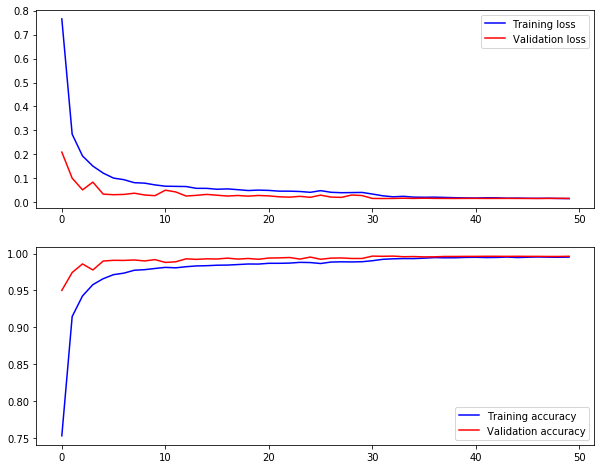

In [31]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation loss', axes=ax[0])
ax[0].legend()

ax[1].plot(history.history['acc'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_acc'], color='r', label='Validation accuracy')
ax[1].legend()

You can see it gets very high accuracy starting around epoch 15! Let's now look at the confusion matrix. Don't worry though, it isn't as confusing as it sounds. A confusion matrix is helpful for seeing what the algorithm got right and what it got wrong.

In [32]:
# Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes, figsize,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(1,1, figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
#     return ax

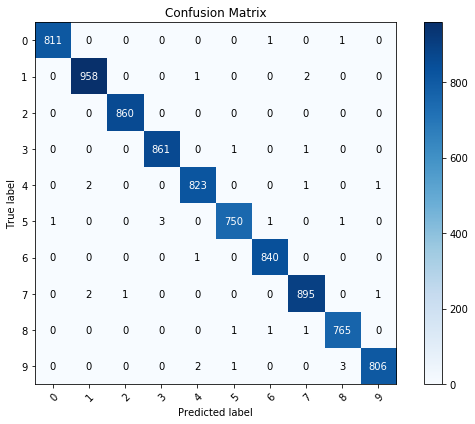

In [33]:
y_true = np.argmax(Y_val, axis=1)
y_pred = cnn_model_datagen.predict(X_val_img)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_true, y_pred, range(10), (8,6), False, 'Confusion Matrix')

The above is the confusion matrix. Down the diagonal from top-left to bottom-right you can see the number of predicted labels the Network correctly classified. Taking a look at prediction label 4, true label 9, you can see the value 2. This means that the Network misclassified two 9's and 4. That isn't bad considering it correctly identified so many!

This is great! Using a pretty simple CNN with augmented data we were able to achieve an accuracy of over 99.6%! Of course this is only for data that already exists. You might be wondering how the model performs on real world data in real time. Let's find out!

In [34]:
cnn_model_datagen.save('mnist_cnn_model.h5')